# Figure 7: Genetics analysis of GWAS Catalog

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import vcf, utilities
from utilities import genetics


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
GWASDIR = os.path.join(PROJECT, 'genetics', 'gwas')
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_07", "gwas")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [6]:
with open(os.path.join(RESDIR, "gwas.significant_sites.pickle"), mode = 'rb') as handle:
    gwas_filt = pickle.load(handle)

gwas_filt_xte = gwas_filt.loc[gwas_filt['referenceFeature'].str.contains("terminal_exon")].copy()
gwas_filt_int = gwas_filt.loc[gwas_filt['referenceFeature'].str.contains("intron")].copy()

print(gwas_filt.shape)
print(gwas_filt_xte.shape)
print(gwas_filt_int.shape)


(200, 43)
(87, 43)
(113, 43)


#### Summarize significant variants

In [22]:
## Quality checks of significance filtering

print("\nPolyaID classification:")
gwas_max_class = gwas_filt[['referenceClassprob','alternateClassprob']].max(axis = 1)
print(gwas_max_class.describe())


print("\nPolyaStrength score:")
gwas_max_str = gwas_filt[['referenceStrength','alternateStrength']].max(axis = 1)
print(gwas_max_str.describe())


print("\nPolyaStrength change:")
gwas_delta_str = gwas_filt['alternateStrength'] - gwas_filt['referenceStrength']
print(abs(gwas_delta_str).describe())


print("\nComposite intronic usage:")
gwas_max_ic = gwas_filt.loc[gwas_filt['referenceFeature'] == 'intron:composite', ['referenceICprob','alternateICprob']].max(axis = 1)
print(gwas_max_ic.describe())


print("\nSkipped intronic usage:")
gwas_max_is = gwas_filt.loc[gwas_filt['referenceFeature'] == 'intron:skipped', ['referenceISprob','alternateISprob']].max(axis = 1)
print(gwas_max_is.describe())



PolyaID classification:
count    200.000000
mean       0.989360
std        0.019093
min        0.906737
25%        0.987963
50%        0.998302
75%        0.999584
max        0.999979
dtype: float64

PolyaStrength score:
count    200.000000
mean      -1.596525
std        3.121021
min       -8.825758
25%       -3.458977
50%       -1.231789
75%        0.013339
max        9.650351
dtype: float64

PolyaStrength change:
count    200.000000
mean       2.401053
std        2.229037
min        1.000959
25%        1.077643
50%        1.248089
75%        2.935051
max       12.666848
dtype: float64

Composite intronic usage:
count    106.000000
mean       0.949172
std        0.027813
min        0.902492
25%        0.924529
50%        0.949334
75%        0.973183
max        0.999829
dtype: float64

Skipped intronic usage:
count    7.000000
mean     0.956882
std      0.034385
min      0.909158
25%      0.930408
50%      0.963390
75%      0.985380
max      0.994051
dtype: float64


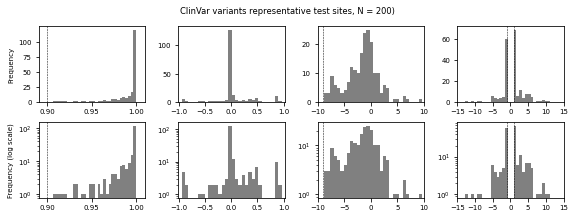

In [7]:
fig,ax = plt.subplots(2,4, figsize = (8,3))
ax = ax.T

for a in ax[0]:
    a.hist(gwas_filt[['referenceClassprob','alternateClassprob']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = 0.9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.05))
    a.set_xlim(0.89,1.01)

for a in ax[1]:
    a.hist(gwas_filt['deltaClassification'], color = 'gray', bins = 30)
    a.xaxis.set_major_locator(MultipleLocator(0.5))
    a.set_xlim(-1.02,1.02)

for a in ax[2]:
    a.hist(gwas_filt[['referenceStrength','alternateStrength']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = -9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    a.set_xlim(-10,10)

for a in ax[3]:
    a.hist(gwas_filt['deltaStrength'], color = 'gray', bins = 30)
    a.axvline(x = -1, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.axvline(x = +1, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    a.set_xlim(-15,15)
    
for a in ax[:,1]:
    a.set_yscale('log')

ax[0][0].set_ylabel("Frequency")
ax[0][1].set_ylabel("Frequency (log scale)")

plt.suptitle(f"ClinVar variants representative test sites, N = {len(gwas_filt):,d})")
plt.tight_layout()
plt.show()


In [8]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites      {gwas_filt_xte.shape[0]:6}")
print(f"Number of unique variants            {gwas_filt_xte.variantID.nunique():6}")
print(f"Number of variants affecting >1 gene {(gwas_filt_xte.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{gwas_filt_xte.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{gwas_filt_xte.directionEffect.value_counts()}")


print("\n### Intronic:")
print(f"Number of variant-pA test sites      {gwas_filt_int.shape[0]:6}")
print(f"Number of unique variants            {gwas_filt_int.variantID.nunique():6}")
print(f"Number of variants affecting >1 gene {(gwas_filt_int.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{gwas_filt_int.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{gwas_filt_int.directionEffect.value_counts()}")



### Extended/terminal exonic:
Number of variant-pA test sites          87
Number of unique variants                86
Number of variants affecting >1 gene      1

Number of types of sites-
terminal_exon             63
extended_terminal_exon    24
Name: referenceFeature, dtype: int64

Direction of effects on strength-
weakened        47
strengthened    40
Name: directionEffect, dtype: int64

### Intronic:
Number of variant-pA test sites         113
Number of unique variants               107
Number of variants affecting >1 gene      3

Number of types of sites-
intron:composite    106
intron:skipped        7
Name: referenceFeature, dtype: int64

Direction of effects on strength-
strengthened    74
weakened        39
Name: directionEffect, dtype: int64


#### Split variant representative sites by their effect on APA activity and save to BED files

In [9]:
test_bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']

gwas_filt['positionTest+1'] = gwas_filt['positionTest']+1

gwas_filt['label'] = gwas_filt['variantID']
gwas_filt['label'] = gwas_filt['label'] + "|" + gwas_filt['reference'] + ">" + gwas_filt['alternate']
gwas_filt['label'] = gwas_filt['label'] + "|" + gwas_filt['affectedMotif']
gwas_filt['label'] = gwas_filt['label'] + "|dID=" + gwas_filt['deltaClassification'].round(3).astype(str) + "(" + gwas_filt['referenceClassprob'].round(3).astype(str) + ">" + gwas_filt['alternateClassprob'].round(3).astype(str) + ")"
gwas_filt['label'] = gwas_filt['label'] + "|dSTR=" + gwas_filt['deltaStrengthProb'].round(3).astype(str) + "(" + gwas_filt['referenceStrengthProb'].round(3).astype(str) + ">" + gwas_filt['alternateStrengthProb'].round(3).astype(str) + ")"

gwas_filt.loc[gwas_filt['referenceFeature'] == 'intron:composite', 'label'] = gwas_filt['label'] + "|dIC=" + (gwas_filt['alternateICprob'] - gwas_filt['referenceICprob']).round(3).astype(str) + "(" + gwas_filt['referenceICprob'].round(3).astype(str) + ">" + gwas_filt['alternateICprob'].round(3).astype(str) + ")"
gwas_filt.loc[gwas_filt['referenceFeature'] == 'intron:skipped', 'label'] = gwas_filt['label'] + "|dIS=" + (gwas_filt['alternateISprob'] - gwas_filt['referenceISprob']).round(3).astype(str) + "(" + gwas_filt['referenceISprob'].round(3).astype(str) + ">" + gwas_filt['alternateISprob'].round(3).astype(str) + ")"

gwas_filt['label'] = gwas_filt['label'] + "|" + gwas_filt['directionEffect']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    for direction in ['strengthened','weakened','mixed']:

        (gwas_filt.loc[(gwas_filt['strand'] == strand) & (gwas_filt['directionEffect'] == direction), test_bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'gwas.representative_sites.significant.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


#### Annotate clinical associations to variants and remove those with no disease relevance

In [10]:
gwas_filt_long = gwas_filt.explode('condition').reset_index(drop = True)
gwas_filt_long['label'] = gwas_filt_long['label'] + "|" + gwas_filt_long['condition']

gwas_filt_assoc = gwas_filt_long.loc[~gwas_filt_long['condition'].isin(['not_provided','not_specified','NA'])].copy()
assoc_int = gwas_filt_assoc.loc[gwas_filt_assoc.referenceFeature.str.contains('intron')]
assoc_xte = gwas_filt_assoc.loc[gwas_filt_assoc.referenceFeature.str.contains('terminal_exon')]

print("\nDataset\t\tShape\t\tGenes Variants Combinations")
print(f"gwas_filt      \t{gwas_filt.shape}\t{gwas_filt.gene.nunique():5} {gwas_filt.variantID.nunique():8} {gwas_filt.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"gwas_filt_long \t{gwas_filt_long.shape}\t{gwas_filt_long.gene.nunique():5} {gwas_filt_long.variantID.nunique():8} {gwas_filt_long.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"gwas_filt_assoc\t{gwas_filt_assoc.shape}\t{gwas_filt_assoc.gene.nunique():5} {gwas_filt_assoc.variantID.nunique():8} {gwas_filt_assoc.groupby(['variantID','gene']).size().shape[0]:12}")

print("\nSplit by genomic feature:")
print("Feature\t\tShape\t\tGenes Variants Combinations")
print(f"intronic       \t{assoc_int.shape}\t{assoc_int.gene.nunique():5} {assoc_int.variantID.nunique():8} {assoc_int.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"terminal exonic\t{assoc_xte.shape}\t{assoc_xte.gene.nunique():5} {assoc_xte.variantID.nunique():8} {assoc_xte.groupby(['variantID','gene']).size().shape[0]:12}")



Dataset		Shape		Genes Variants Combinations
gwas_filt      	(200, 45)	  199      192          200
gwas_filt_long 	(348, 45)	  199      192          200
gwas_filt_assoc	(338, 45)	  189      182          190

Split by genomic feature:
Feature		Shape		Genes Variants Combinations
intronic       	(156, 45)	  108      102          108
terminal exonic	(182, 45)	   81       81           82


In [11]:
gwas_filt_assoc['condition'].value_counts()

body height                                  13
erythrocyte count                            11
body mass index                               7
mean corpuscular volume                       6
mean corpuscular hemoglobin concentration     5
                                             ..
Myopia                                        1
glomerular filtration rate                    1
 Menorrhagia                                  1
emotional symptom measurement                 1
Abnormality of refraction                     1
Name: condition, Length: 207, dtype: int64

#### Create annotated VCF file of significant variants

In [12]:
### annotate vcf with representative site info

filtered_ids = list(set(gwas_filt_long['variantID'].tolist()))
print("# Included IDs:", len(filtered_ids))

annotation_to_add = {
    'representative_test_position'        : 'positionTest',
    'representative_test_position_feature': 'referenceFeature',
    'variant_distance_to_test_position'   : 'testSiteDistStranded',
    'variant_affected_motif_details'      : 'affectedMotifs',
    'variant_clinical_associations'       : 'condition',
    'ref_classification'                  : 'referenceClassprob',
    'alt_classification'                  : 'alternateClassprob',
    'ref_strength'                        : 'referenceStrength',
    'alt_strength'                        : 'alternateStrength',
    'ref_strength_probability'            : 'referenceStrengthProb',
    'alt_strength_probability'            : 'alternateStrengthProb',
    'ref_peak_clv_profile'                : 'referenceNormClvProfile',
    'alt_peak_clv_profile'                : 'alternateNormClvProfile',
    'ref_intron_composite_usage'          : 'referenceICprob',
    'alt_intron_composite_usage'          : 'alternateICprob',
    'ref_intron_skipped_usage'            : 'referenceISprob',
    'alt_intron_skipped_usage'            : 'alternateISprob',
    'delta_probability_classification'    : 'deltaClassification',
    'delta_probability_strength'          : 'deltaStrengthProb',
    'delta_logit_strength'                : 'deltaStrength',
}

vcf_te = os.path.join(GWASDIR, 'gwas.pc.max_100.fully_within_xte.affected_motifs_sig_complete.vcf')
vcf_int = os.path.join(GWASDIR, 'gwas.pc.max_100.fully_within_intron.affected_motifs_sig_complete.vcf')

vcf_te_reader  = vcf.Reader(open(vcf_te, 'r'))
vcf_int_reader = vcf.Reader(open(vcf_int, 'r'))

vcf_out1 = os.path.join(GWASDIR, 'gwas.pc.max_100.fully_within_feature.affected_motifs_sig_complete.significant.vcf')
vcf_out1_writer = vcf.Writer(open(vcf_out1, 'w'), vcf_te_reader)

vcf_out2 = os.path.join(OUTDIR, 'gwas.significant.vcf')
vcf_out2_writer = vcf.Writer(open(vcf_out2, 'w'), vcf_te_reader)

for record in tqdm.tqdm(vcf_te_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(gwas_filt_long, record.ID, dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()
        
        
for record in tqdm.tqdm(vcf_int_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(gwas_filt_long, record.ID, dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()

        
vcf_out1_writer.close()
vcf_out2_writer.close()
    

# Included IDs: 192


7348it [00:01, 3986.34it/s]
39965it [00:03, 12036.69it/s]


#### Save overall table

In [13]:
out_cols = [
    'variantID',
    'chrom', 'position', 'reference', 'alternate',
    'gene', 'geneStrand', 'positionTest', 'testSiteDistStranded',
    'referenceFeature',
    'referenceClassprob', 'alternateClassprob', 'deltaClassification',
    'referenceStrength', 'alternateStrength', 'deltaStrength', 
    'referenceICprob', 'alternateICprob', 
    'referenceISprob', 'alternateISprob', 
    'affectedMotifs', 'condition']

out_data = (gwas_filt[out_cols]
            .drop_duplicates(subset = out_cols[:9])
            .sort_values(['chrom','positionTest'])
)

out_data.to_csv(os.path.join(OUTDIR, f'gwas.representative_sites.significant.txt'), sep = "\t", index = False)
print(out_data.shape)


(200, 22)


#### Make accompanying tracks

In [14]:
bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']
bedgraph_cols = ['chrom','positionTest','positionTest+1']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    strand_data = gwas_filt_long.loc[gwas_filt_long['strand'] == strand]
    
    (strand_data[bed_cols]
     .drop_duplicates()
     .sort_values(['chrom','positionTest'])
     .to_csv(os.path.join(OUTDIR, f'gwas.significant.disease_assoc.{strand_str}.bed'), sep = "\t", index = False, header = False)
    )
    
    for score in ['referenceClassprob','alternateClassprob','referenceStrength','alternateStrength', 'referenceStrengthProb', 'alternateStrengthProb']:
        
        (strand_data[bedgraph_cols + [score]]
         .drop_duplicates()
         .sort_values(['chrom','positionTest'])
         .groupby(['chrom','positionTest','positionTest+1']).agg('max').reset_index()
         .to_csv(os.path.join(OUTDIR, f'gwas.significant.disease_assoc.{score}.{strand_str}.bedgraph'), sep = "\t", index = False, header = False)
        )
        
    for direction in ['strengthened','weakened','mixed']:

        (strand_data.loc[strand_data['directionEffect'] == direction, bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'gwas.significant.disease_assoc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


## Analyze significant variants

### Variants affecting extended/terminal exonic sites

#### Visualize the distribution of variants around the representative test sites

In [15]:
paper_examples = ['rs3211995']
extreme_values = ['rs78378222','rs777513','rs986475','rs10954213','rs1488763','rs4395360','rs8030','rs1053815','rs7460815']

gwas_filt_xte['examples'] = np.nan
gwas_filt_xte.loc[gwas_filt_xte['variantID'].isin(extreme_values), 'examples'] = 'extreme'
gwas_filt_xte.loc[gwas_filt_xte['variantID'].isin(paper_examples), 'examples'] = 'paper'


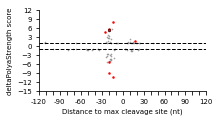

In [16]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +1, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = gwas_filt_xte, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 2, alpha = 0.75, ax = ax)

sns.scatterplot(data = gwas_filt_xte.loc[(gwas_filt_xte['variantID'].isin(extreme_values))], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, ax = ax)

sns.scatterplot(data = gwas_filt_xte.loc[(gwas_filt_xte['variantID'].isin(paper_examples))], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,12)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel("deltaPolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'gwas.xte.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [17]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength']
gwas_filt_xte.loc[gwas_filt_xte['variantID'].isin(paper_examples), preview_cols].sort_values('testSiteDistStranded')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength
68,rs3211995,SLC9A3R2,created_AATAAA|AATAAA,-19,0.232017,5.358871


In [18]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength']
gwas_filt_xte.loc[gwas_filt_xte['variantID'].isin(extreme_values), preview_cols].sort_values('testSiteDistStranded')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength
141,rs4395360,SLC66A1L,created_AATAAA|AATAAA,-25,0.522357,4.567686
139,rs1488763,GPR156,created_AATAAA|AATAAA,-20,0.891828,5.728798
164,rs986475,NCR3,disrupted_AATAAA|AATAAA,-20,-0.897791,-5.429685
140,rs777513,UROC1,disrupted_AATAAA|AATAAA,-19,-0.111343,-9.077299
77,rs78378222,TP53,disrupted_AATAAA|AATAAA,-14,-0.184303,-10.303949
182,rs10954213,IRF5,created_AATAAA|AATAAA,-14,0.378763,8.083775
188,rs7460815,ZDHHC2,created_GT/CT-Rich|TGTGAT,17,0.000446,1.499645


#### Summarize the motifs affected by variants

In [19]:
gwas_sum_dt = (
    assoc_xte.loc[assoc_xte['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

gwas_sum = (gwas_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

gwas_sum['Proportion'] = gwas_sum['Count'] / gwas_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(gwas_sum_dt.shape)
print(gwas_sum_dt.variantID.nunique())
print(gwas_sum['Count'].sum())


(82, 3)
81
82


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
notebook_setup.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  from textwrap import wrap


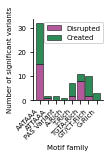

In [20]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA-Rich','GT/CT-Rich','G-Rich']

disrupted_props = gwas_sum.loc[gwas_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = gwas_sum.loc[gwas_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, disrupted_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

# ax.set_ylim(0,30)
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'gwas.xte.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Examples of disease-related variants and gene


##########
SLC9A3R2

Associated conditions-	 body mass index
			erythrocyte count 

variantID                              rs3211995
chrom                                      chr16
position                                 2039005
strand                                         +
reference                                      G
alternate                                      A
gene                                    SLC9A3R2
geneStrand                                     +
affectedMotif            created_AATAAA_SLC9A3R2
positionTest                             2039025
testSiteDistStranded                         -19
referenceFeature                   terminal_exon
referenceClassprob                      0.767061
alternateClassprob                      0.999078
deltaClassification                     0.232017
referenceStrength                       -6.77848
alternateStrength                       -1.41961
deltaStrength                            5.35887
referenceStrengthProb            

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


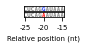

TGACTTTGCACTTCCCTCCCGGGCCCCGCACCCCCGAACCGACCACCGATCGACCGGCACCGCTGTTGCCTCGTAAGCCATAGCGCATGCGCGCTCTCAGGATAAACAGGCCCTGCCTGGGACCCACACGCCTCTGTCTTTTCTGAGCCTCCTCCCCGTGGGGTGAGAGGGGTGGAGGGATGAGGCTGTTTCAGGGAGCCCCCTCCCCGAGTCTCAGCAGCTGGAAACGGTCTCGTTCCT
TGACTTTGCACTTCCCTCCCGGGCCCCGCACCCCCGAACCGACCACCGATCGACCGGCACCGCTGTTGCCTCGTAAGCCATAGCGCATGCGCGCTCTCAGAATAAACAGGCCCTGCCTGGGACCCACACGCCTCTGTCTTTTCTGAGCCTCCTCCCCGTGGGGTGAGAGGGGTGGAGGGATGAGGCTGTTTCAGGGAGCCCCCTCCCCGAGTCTCAGCAGCTGGAAACGGTCTCGTTCCT


In [21]:
example_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                'referenceClassprob', 'alternateClassprob','deltaClassification',
                'referenceStrength', 'alternateStrength', 'deltaStrength',
                'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                'affectedMotifs', 'condition',
                'clinical_significance']

example_ids = ['rs3211995']
example_gene = ['SLC9A3R2']
example_range = [(120-25,120-15+1)]

for eid, egene, erange in zip(example_ids, example_gene, example_range):
    
    if (eid == ''):
        continue
    
    print(f"\n##########\n{egene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(gwas_filt_long.loc[(gwas_filt_long['variantID'] == eid) & (~gwas_filt_long['condition'].isin(['not_provided','not_specified','NA'])), 'condition'].tolist()))), "\n")
    print(gwas_filt_long.loc[gwas_filt_long['variantID'] == eid].iloc[0][example_cols])
    
    e_name = f'ukbb.{eid}.{egene}'
    e_data = gwas_filt_long.loc[(gwas_filt_long['variantID'] == eid) & (gwas_filt_long['gene'] == egene)].iloc[0]

    genetics.plot_variant_logo(os.path.join(OUTDIR, f'variant_examples.gwas.{e_name}.svg'),
                               e_data['referenceSequence'], e_data['alternateSequence'], 
                               erange, [120+e_data['testSiteDistStranded']-len(e_data['reference'])])
    
    print(e_data['referenceSequence'])
    print(e_data['alternateSequence'])
